In [ ]:
import csv
import torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import AdamW, BertTokenizer, BertForSequenceClassification

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:

# Specify input file path
input_file_path = 'english_telugu_data.txt'

# Specify output file path
output_file_path = 'teluguenglishseparate11.csv'

# Read data from the input file
with open(input_file_path, 'r', encoding='utf-8') as infile:
    telugudata = [line.strip().split('++++$++++') for line in infile]

# Write data to CSV with separate columns for Telugu and English
with open(output_file_path, 'w', newline='', encoding='utf-8') as csvfile:
    csv_writer = csv.writer(csvfile)

    # Write header
    csv_writer.writerow(['English Text', 'Telugu Text'])

    # Write data rows
    csv_writer.writerows(telugudata)



print(f'CSV file "{output_file_path}" created successfully.')

CSV file "teluguenglishseparate11.csv" created successfully.


In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
# Load the dataset
dataset = pd.read_csv('teluguenglishseparate11.csv')

# Randomly sample 1000 records
# Take the first 80000 records
dataset = dataset.head(80000)

In [ ]:
# Display the first few rows to check the structure
print(dataset.tail())

                                English Text                     Telugu Text
79995  It is on the left side of the street.      ఇది వీధికి ఎడమ వైపున ఉంది.
79996                 I missed the last bus.  నేను చివరి బస్సును కోల్పోయాను.
79997  This is the watch I bought yesterday.      నేను నిన్న కొన్న వాచ్ ఇదే.
79998              Do you have Saturday off?        మీకు శనివారం సెలవు ఉందా?
79999           Tom fell asleep immediately.        టామ్ వెంటనే నిద్రపోయాడు.


In [ ]:



from transformers import MarianMTModel, MarianTokenizer
import sentencepiece as spm

model_name = "Helsinki-NLP/opus-mt-en-hi"
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [ ]:
# Set up the model for fine-tuning
device = torch.device("cuda")
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        english_text = str(self.data.iloc[idx]['English Text'])
        telugu_text = str(self.data.iloc[idx]['Telugu Text'])

        # Tokenize and encode the inputs
        inputs = self.tokenizer(
            english_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True
        )

        # Tokenize and encode the labels
        labels = self.tokenizer(
            telugu_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True
        )

        # Return the tokenized inputs and labels
        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "labels": labels["input_ids"].squeeze()  # Treat Telugu text as labels
        }


# Split the dataset into training and validation sets
train_data, temp_data = train_test_split(dataset, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Use your CustomDataset class
train_dataset = CustomDataset(train_data, tokenizer)
val_dataset = CustomDataset(val_data, tokenizer)
test_dataset = CustomDataset(test_data, tokenizer)

# Create PyTorch DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)



In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Use tqdm to display a progress bar
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch"):
        optimizer.zero_grad()
        inputs = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print("Training finished.")

Epoch 1/10: 100%|██████████| 16000/16000 [28:55<00:00,  9.22batch/s]


Epoch 1/10, Average Loss: 0.0239


Epoch 2/10: 100%|██████████| 16000/16000 [28:49<00:00,  9.25batch/s]


Epoch 2/10, Average Loss: 0.0085


Epoch 3/10: 100%|██████████| 16000/16000 [28:52<00:00,  9.24batch/s]


Epoch 3/10, Average Loss: 0.0071


Epoch 4/10: 100%|██████████| 16000/16000 [28:49<00:00,  9.25batch/s]


Epoch 4/10, Average Loss: 0.0061


Epoch 5/10: 100%|██████████| 16000/16000 [28:47<00:00,  9.26batch/s]


Epoch 5/10, Average Loss: 0.0053


Epoch 6/10: 100%|██████████| 16000/16000 [28:52<00:00,  9.23batch/s]


Epoch 6/10, Average Loss: 0.0046


Epoch 7/10: 100%|██████████| 16000/16000 [28:54<00:00,  9.23batch/s]


Epoch 7/10, Average Loss: 0.0040


Epoch 8/10: 100%|██████████| 16000/16000 [28:53<00:00,  9.23batch/s]


Epoch 8/10, Average Loss: 0.0035


Epoch 9/10: 100%|██████████| 16000/16000 [28:51<00:00,  9.24batch/s]


Epoch 9/10, Average Loss: 0.0030


Epoch 10/10: 100%|██████████| 16000/16000 [28:52<00:00,  9.23batch/s]

Epoch 10/10, Average Loss: 0.0027
Training finished.


In [ ]:
model.eval()
with torch.no_grad():
    for val_batch in val_dataloader:  # Assuming you have a DataLoader for your validation set
        val_inputs = val_batch["input_ids"].to(device)
        val_labels = val_batch["labels"].to(device)

        val_outputs = model(val_inputs, labels=val_labels)
        val_loss = val_outputs.loss

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Validation Loss: {avg_val_loss}")


Validation Loss: 3.9389281170088e-08


In [ ]:
model.save_pretrained("fine_tuned_model3")
tokenizer.save_pretrained("fine_tuned_model3")


('fine_tuned_model3/tokenizer_config.json',
 'fine_tuned_model3/special_tokens_map.json',
 'fine_tuned_model3/vocab.json',
 'fine_tuned_model3/source.spm',
 'fine_tuned_model3/target.spm',
 'fine_tuned_model3/added_tokens.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from transformers import MarianMTModel, MarianTokenizer

# Load the fine-tuned model and tokenizer
loaded_model = MarianMTModel.from_pretrained("fine_tuned_model3")
loaded_tokenizer = MarianTokenizer.from_pretrained("fine_tuned_model3")

# Move the loaded model to the desired device (CPU or GPU)
loaded_model.to(device)


/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(61950, 512, padding_idx=61949)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(61950, 512, padding_idx=61949)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

In [1]:
input_text = "Its pretty amazing"
input_ids = loaded_tokenizer.encode(input_text, return_tensors="pt")

# Move input tensor to the same device as the model
input_ids = input_ids.to(loaded_model.device)

# Generate output on the same device
output_ids = loaded_model.generate(input_ids)

# Move output tensor to CPU if needed
output_ids = output_ids.to("cpu")

output_text = loaded_tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(output_text)



చాల అద్బుతంగా


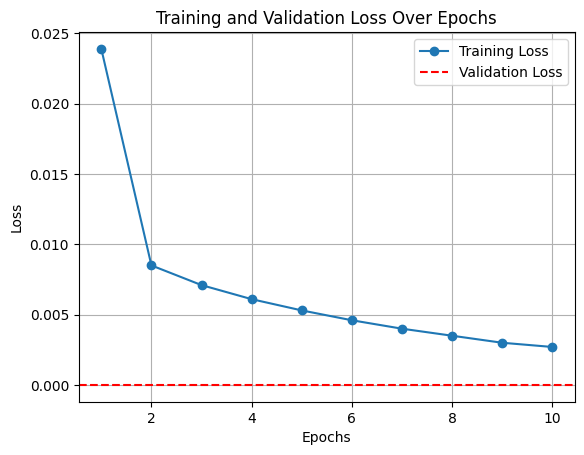

In [ ]:
import matplotlib.pyplot as plt

# Given data
epochs = list(range(1, 11))
training_losses = [0.0239, 0.0085, 0.0071, 0.0061, 0.0053, 0.0046, 0.0040, 0.0035, 0.0030, 0.0027]
validation_loss = 3.9389281170088e-08  # This remains constant

# Plotting the training loss
plt.plot(epochs, training_losses, marker='o', label='Training Loss', linestyle='-')

# Plotting a line for the validation loss
plt.axhline(y=validation_loss, color='r', linestyle='--', label='Validation Loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Showing grid
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
import os
print(os.listdir("/content"))


['.config', 'drive', 'fine_tuned_model', 'teluguenglishseparate11.csv', 'english_telugu_data.txt', 'fine_tuned_model3', 'fine_tuned_model2', 'sample_data']
